In [ ]:
%pip install numpy, matplotlib, opencv-python, jupyterlab

from IPython.core.display import HTML
import pathlib
styles_path = pathlib.Path(pathlib.Path().absolute(), "style", "style.css")
styles = open(styles_path, "r").read()
HTML(f"<style>{styles}</style>")

# 2.0 Image Processing II

### Contents

1.1  \
1.1.1  \
1.1.2  \
1.1.3 

1.2 


&nbsp;

$\large{\text{2.1 Filters as Templates}}$ \
$\large{\text{2.1.1 Template Matching}} $

---

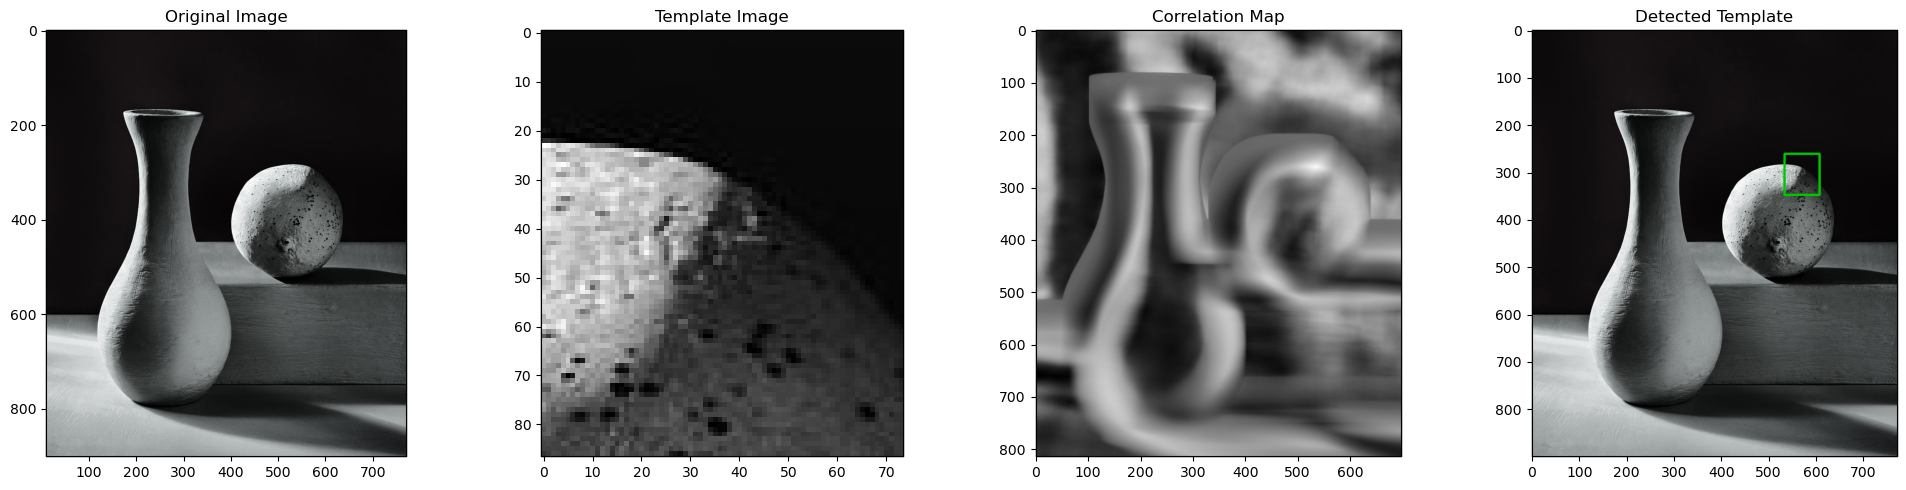

In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def find_template(template_path, target_path):
    template = cv2.imread(template_path, 0)
    target = cv2.imread(target_path, 0)
    original_target = cv2.imread(target_path)  # Load original target image

    res = cv2.matchTemplate(target, template, cv2.TM_CCOEFF_NORMED)

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    top_left = max_loc
    w, h = template.shape[::-1]
    bottom_right = (top_left[0] + w, top_left[1] + h)

    matched_img = original_target.copy()
    cv2.rectangle(matched_img, top_left, bottom_right, (0, 200, 0), 4)  # Green rectangle

    return original_target, template, res, matched_img

def display_images(original_image, template_image, correlation_map, detected_image):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))


    axes[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].set_frame_on(True) 
    axes[0].set_xlim(10, original_image.shape[1]) 
    axes[0].set_ylim(original_image.shape[0])  
    axes[0].patch.set_edgecolor('black')  
    axes[0].patch.set_linewidth(1) 


    axes[1].imshow(template_image, cmap='gray')
    axes[1].set_title('Template Image')
    axes[1].set_frame_on(True)
    axes[1].patch.set_edgecolor('black')
    axes[1].patch.set_linewidth(1)


    axes[2].imshow(correlation_map, cmap='gray')
    axes[2].set_title('Correlation Map')
    axes[2].set_frame_on(True)
    axes[2].patch.set_edgecolor('black')
    axes[2].patch.set_linewidth(1)


    axes[3].imshow(cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB))
    axes[3].set_title('Detected Template')
    axes[3].set_frame_on(True)
    axes[3].patch.set_edgecolor('black')
    axes[3].patch.set_linewidth(1)

    plt.tight_layout()
    plt.show()

template_path = 'img/gaussian_original_template.jpg'
target_path = 'img/gaussian_original.jpg'

# Perform template matching and get images
original_image, template_image, correlation_map, detected_image = find_template(template_path, target_path)

display_images(original_image, template_image, correlation_map, detected_image)


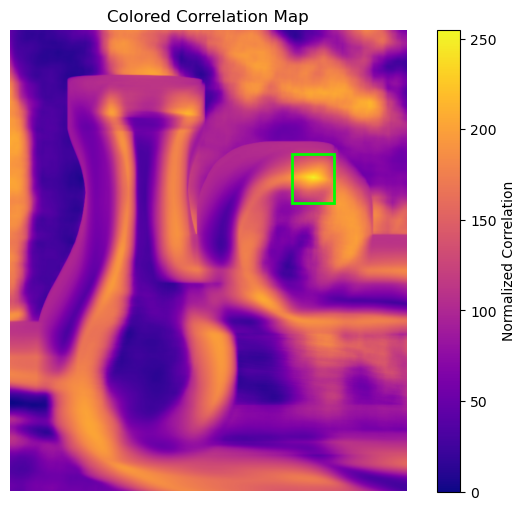

In [76]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_correlation_map(correlation_map, template_size):
    normalized_map = cv2.normalize(correlation_map, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    colormap = plt.get_cmap('plasma') 
    colored_map = (colormap(normalized_map) * 255).astype(np.uint8) 

    # Display the colored correlation map
    plt.figure(figsize=(8, 6))
    plt.imshow(colored_map, cmap='plasma')
    plt.title('Colored Correlation Map')
    plt.colorbar(label='Normalized Correlation')
    plt.axis('off')

    # Find the location of the maximum correlation (top-left corner of the rectangle)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(correlation_map)

    # Adjust the top-left corner to position the rectangle correctly
    top_left = (max_loc[0] - template_size[0] // 2, max_loc[1] - template_size[1] // 2)
    bottom_right = (top_left[0] + template_size[0], top_left[1] + template_size[1])  # Calculate bottom-right corner

    rect = plt.Rectangle((top_left[0], top_left[1]), template_size[0], template_size[1], linewidth=2, edgecolor='lime', facecolor='none')
    plt.gca().add_patch(rect)  # Add rectangle to the plot

    plt.show()

def find_template(template_path, target_path):
    # Load images
    template = cv2.imread(template_path, 0)
    target = cv2.imread(target_path, 0)

    template_size = template.shape[::-1]

    # Perform template matching
    res = cv2.matchTemplate(target, template, cv2.TM_CCOEFF_NORMED)

    return res, template_size

template_path = 'img/gaussian_original_template.jpg'
target_path = 'img/gaussian_original.jpg'

correlation_map, template_size = find_template(template_path, target_path)

visualize_correlation_map(correlation_map, template_size)


The "peaks" in the correlation map directly point to the object location. It is important to note that, this method only works when exact match template of the object is used. In most practical object recognition applications, an exactly matching template may not be used. For example, the task of detecting cars or pedestrians cannot be implemented by using an exact template that provides exact parameters such as viewpoint, scale, orientation, image intensities, or colors, so that a matching could work.

This is because more complex representations preserve semantic similarities between different objects of the same class while at the same time giving different outputs for different classes.

The document will follow from the early stages of visual processing to representations that preserve the similarity between semantic entities in order to perform object detection using mechanisms such as correlation filtering.

$\large{\text{2.1.2 Edge Detection with Derivatives}} $

---

Modulation Transfer Function (MTF) 

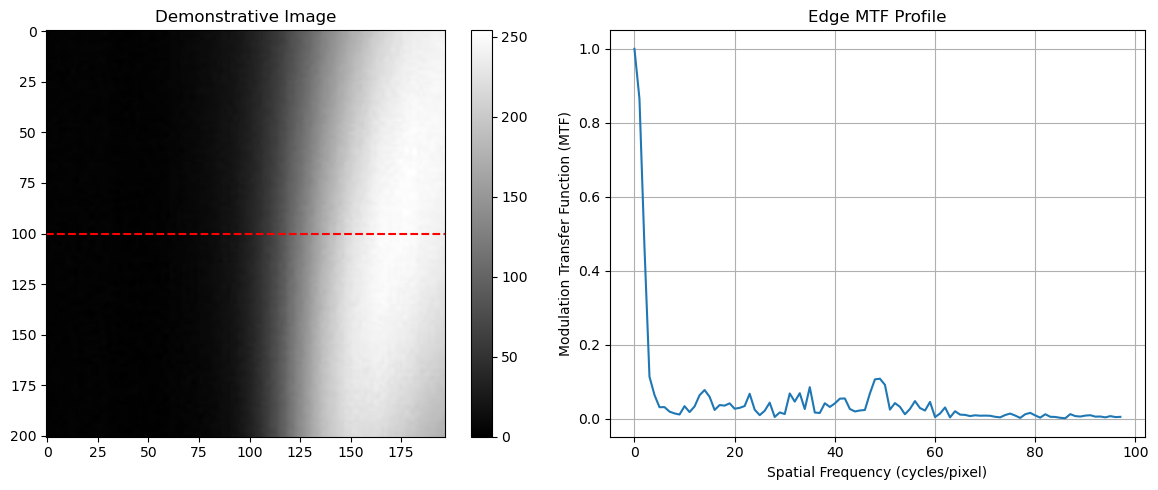

In [32]:
# Modulation Transfer Function
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_mtf_from_image(image_path, section_height):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        print(f"Error: Unable to read image from {image_path}")
        return
    
    # Determine the width and height of the image
    height, width = image.shape
    
    # Define the horizontal section coordinates
    y = int(height / 2)  # Choose the middle row as the section
    x1 = 0               # Starting x-coordinate
    x2 = width           # Ending x-coordinate (end of image)
    
    # Extract the horizontal section from the image
    section = image[y:y+section_height, x1:x2]
    
    # Compute the edge MTF profile
    # Apply Sobel edge detection to the section
    edges = cv2.Sobel(section, cv2.CV_64F, 1, 0, ksize=3)  # Sobel filter along x-axis
    
    # Calculate the MTF by taking the 1D FFT along the x-axis
    mtf_values = np.abs(np.fft.fft(edges.mean(axis=0)))
    mtf_values /= mtf_values[0]  # Normalize to the first value (at 0 frequency)

    # Generate the frequency axis for the MTF plot
    frequency = np.fft.fftfreq(len(mtf_values), d=1.0/width)
    
    # Plot the MTF profile
    plt.figure(figsize=(12, 5))
    
    # Plot the image with the section line
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.axhline(y=y, color='r', linestyle='--', label='Section Line')
    plt.title('Demonstrative Image')
    plt.colorbar()
    
    # Plot the MTF profile
    plt.subplot(1, 2, 2)
    plt.plot(frequency[:width//2], mtf_values[:width//2])  # Plot only positive frequencies
    plt.title('Edge MTF Profile')
    plt.xlabel('Spatial Frequency (cycles/pixel)')
    plt.ylabel('Modulation Transfer Function (MTF)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

image_path = 'img/pixel.png'
section_height = 10  # Number of rows to consider in the section

# Call the function to plot the MTF profile and visualize the image with section line
plot_mtf_from_image(image_path, section_height)


To calculate the location of the edge, we can find maxima of the first derivative. Alternatively, we can look for the zero crossings of the second derivative as well.

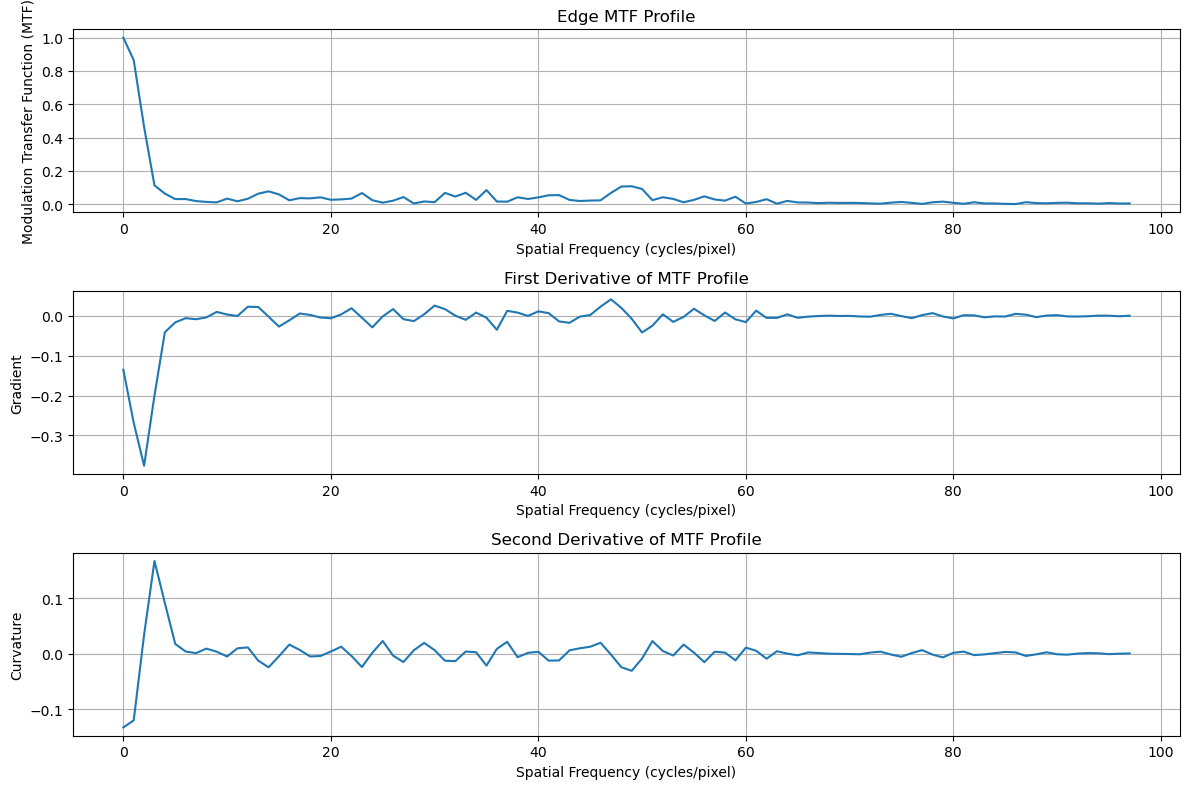

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_mtf_from_image(image_path, section_height):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        print(f"Error: Unable to read image from {image_path}")
        return
    
    # Determine the width and height of the image
    height, width = image.shape
    
    # Define the section coordinates (horizontal line)
    y = int(height / 2)  # Choose the middle row as the section
    x1 = 0               # Starting x-coordinate
    x2 = width           # Ending x-coordinate (end of the image)
    
    # Extract the horizontal section from the image
    section = image[y:y+section_height, x1:x2]
    
    # Compute the edge MTF (Modulation Transfer Function) profile
    # Apply Sobel edge detection to the section
    edges = cv2.Sobel(section, cv2.CV_64F, 1, 0, ksize=3)  # Sobel filter along x-axis
    
    # Calculate the MTF by taking the 1D FFT along the x-axis
    mtf_values = np.abs(np.fft.fft(edges.mean(axis=0)))
    mtf_values /= mtf_values[0]  # Normalize to the first value (at 0 frequency)

    # Generate the frequency axis for the MTF plot
    frequency = np.fft.fftfreq(len(mtf_values), d=1.0/width)
    
    # Calculate the first derivative (gradient) of the MTF profile
    mtf_gradient = np.gradient(mtf_values, frequency)
    
    # Calculate the second derivative (curvature) of the MTF profile
    mtf_curvature = np.gradient(mtf_gradient, frequency)
    
    # Plot the MTF profile, first derivative, and second derivative
    plt.figure(figsize=(12, 8))
    
    # Plot the original MTF profile
    plt.subplot(3, 1, 1)
    plt.plot(frequency[:width//2], mtf_values[:width//2])
    plt.title('Edge MTF Profile')
    plt.xlabel('Spatial Frequency (cycles/pixel)')
    plt.ylabel('Modulation Transfer Function (MTF)')
    plt.grid(True)
    
    # Plot the first derivative (gradient) of the MTF profile
    plt.subplot(3, 1, 2)
    plt.plot(frequency[:width//2], mtf_gradient[:width//2])
    plt.title('First Derivative of MTF Profile')
    plt.xlabel('Spatial Frequency (cycles/pixel)')
    plt.ylabel('Gradient')
    plt.grid(True)
    
    # Plot the second derivative (curvature) of the MTF profile
    plt.subplot(3, 1, 3)
    plt.plot(frequency[:width//2], mtf_curvature[:width//2])
    plt.title('Second Derivative of MTF Profile')
    plt.xlabel('Spatial Frequency (cycles/pixel)')
    plt.ylabel('Curvature')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Specify the path to your image and section height
image_path = 'img/pixel.png'
section_height = 10  # Number of rows to consider in the section

# Call the function to plot the MTF profile and derivatives
plot_mtf_from_image(image_path, section_height)


For the 2D function $f(x,y)$ the partial derivative is:

$  \frac{\partial f(x,y)}{\partial x} = \lim_{{\epsilon \to 0}} \frac{f(x +\epsilon, y) - f(x, y)}{\epsilon} $


However, when we want to apply this to images, we have the problem that images are not continuous functions, and rather discrete representations, and therefore the values of pixels are defined at discrete pixel locations. For discrete data, we can approximate the continuous definition of the derivative using finite differences:

$ \frac{\partial f(x,y)}{\partial x} \approx \frac{f(x + 1, y) - f(x, y)}{1} $